<h2> Predict heart disease and investigate causes </h2>

<b> Business Case </b>

The goal is to determine the presence of heart disease in the patient. Of all the applications of machine-learning, diagnosing any serious disease using a black box is always going to be a hard sell. If the output from a model is the particular course of treatment (potentially with side-effects), or surgery, or the absence of treatment, people are going to want to know why.

<b> Data </b>

This database contains 76 attributes, but all published experiments refer to using a subset of 14 of them. In particular, the Cleveland database is the only one that has been used by ML researchers to this date. It is integer valued from 0 (no presence) to 4.



<b> Importing and loading data </b>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns #for plotting
from sklearn.ensemble import RandomForestClassifier #for the model
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz #plot tree
from sklearn.metrics import roc_curve, auc #for model evaluation
from sklearn.metrics import classification_report #for model evaluation
from sklearn.metrics import confusion_matrix #for model evaluation
from sklearn.model_selection import train_test_split #for data splitting
import eli5 #for purmutation importance
from eli5.sklearn import PermutationImportance
import shap #for SHAP values
from pdpbox import pdp, info_plots #for partial plots

pd.options.mode.chained_assignment = None  #hide any pandas warnings

<a id='section2'></a>

<b> Exploratory Data Analysis and Feature Engineering </b>

In [2]:
df = pd.read_csv("./data/heart.csv")

In [3]:
df.head(10)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
5,57,1,0,140,192,0,1,148,0,0.4,1,0,1,1
6,56,0,1,140,294,0,0,153,0,1.3,1,0,2,1
7,44,1,1,120,263,0,1,173,0,0.0,2,0,3,1
8,52,1,2,172,199,1,1,162,0,0.5,2,0,3,1
9,57,1,2,150,168,0,1,174,0,1.6,2,0,2,1


- **age**: The person's age in years
- **sex**: The person's sex (1 = male, 0 = female)
- **cp:** The chest pain experienced (Value 1: typical angina, Value 2: atypical angina, Value 3: non-anginal pain, Value 4: asymptomatic)
- **trestbps:** The person's resting blood pressure (mm Hg on admission to the hospital)
- **chol:** The person's cholesterol measurement in mg/dl
- **fbs:** The person's fasting blood sugar (> 120 mg/dl, 1 = true; 0 = false) 
- **restecg:** Resting electrocardiographic measurement (0 = normal, 1 = having ST-T wave abnormality, 2 = showing probable or definite left ventricular hypertrophy by Estes' criteria)
- **thalach:** The person's maximum heart rate achieved
- **exang:** Exercise induced angina (1 = yes; 0 = no)
- **oldpeak:** ST depression induced by exercise relative to rest ('ST' relates to positions on the ECG plot. See more [here](https://litfl.com/st-segment-ecg-library/))
- **slope:** the slope of the peak exercise ST segment (Value 1: upsloping, Value 2: flat, Value 3: downsloping)
- **ca:** The number of major vessels (0-3)
- **thal:** A blood disorder called thalassemia (3 = normal; 6 = fixed defect; 7 = reversable defect)
- **target:** Heart disease (0 = no, 1 = yes)

In [4]:
# change column names for interpretability
df.columns = ['age', 'sex', 'chest_pain_type', 'resting_blood_pressure', 'cholesterol', 'fasting_blood_sugar', 'rest_ecg', 'max_heart_rate_achieved',
       'exercise_induced_angina', 'st_depression', 'st_slope', 'num_major_vessels', 'thalassemia', 'target']

In [5]:
# create categorical variables labels for interpretability
df['sex'][df['sex'] == 0] = 'female'
df['sex'][df['sex'] == 1] = 'male'

df['chest_pain_type'][df['chest_pain_type'] == 1] = 'typical angina'
df['chest_pain_type'][df['chest_pain_type'] == 2] = 'atypical angina'
df['chest_pain_type'][df['chest_pain_type'] == 3] = 'non-anginal pain'
df['chest_pain_type'][df['chest_pain_type'] == 4] = 'asymptomatic'

df['fasting_blood_sugar'][df['fasting_blood_sugar'] == 0] = 'lower than 120mg/ml'
df['fasting_blood_sugar'][df['fasting_blood_sugar'] == 1] = 'greater than 120mg/ml'

df['rest_ecg'][df['rest_ecg'] == 0] = 'normal'
df['rest_ecg'][df['rest_ecg'] == 1] = 'ST-T wave abnormality'
df['rest_ecg'][df['rest_ecg'] == 2] = 'left ventricular hypertrophy'

df['exercise_induced_angina'][df['exercise_induced_angina'] == 0] = 'no'
df['exercise_induced_angina'][df['exercise_induced_angina'] == 1] = 'yes'

df['st_slope'][df['st_slope'] == 1] = 'upsloping'
df['st_slope'][df['st_slope'] == 2] = 'flat'
df['st_slope'][df['st_slope'] == 3] = 'downsloping'

df['thalassemia'][df['thalassemia'] == 1] = 'normal'
df['thalassemia'][df['thalassemia'] == 2] = 'fixed defect'
df['thalassemia'][df['thalassemia'] == 3] = 'reversable defect'


In [6]:
# check data types
df.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [7]:
# check missing values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 14 columns):
age                        303 non-null int64
sex                        303 non-null object
chest_pain_type            303 non-null object
resting_blood_pressure     303 non-null int64
cholesterol                303 non-null int64
fasting_blood_sugar        303 non-null object
rest_ecg                   303 non-null object
max_heart_rate_achieved    303 non-null int64
exercise_induced_angina    303 non-null object
st_depression              303 non-null float64
st_slope                   303 non-null object
num_major_vessels          303 non-null int64
thalassemia                303 non-null object
target                     303 non-null int64
dtypes: float64(1), int64(6), object(7)
memory usage: 33.2+ KB


In [8]:
# change to categorical variables
df['sex'] = df['sex'].astype('object')
df['chest_pain_type'] = df['chest_pain_type'].astype('object')
df['fasting_blood_sugar'] = df['fasting_blood_sugar'].astype('object')
df['rest_ecg'] = df['rest_ecg'].astype('object')
df['exercise_induced_angina'] = df['exercise_induced_angina'].astype('object')
df['st_slope'] = df['st_slope'].astype('object')
df['thalassemia'] = df['thalassemia'].astype('object')
df.dtypes

age                          int64
sex                         object
chest_pain_type             object
resting_blood_pressure       int64
cholesterol                  int64
fasting_blood_sugar         object
rest_ecg                    object
max_heart_rate_achieved      int64
exercise_induced_angina     object
st_depression              float64
st_slope                    object
num_major_vessels            int64
thalassemia                 object
target                       int64
dtype: object

In [9]:
# create dummy variables
df = pd.get_dummies(df, drop_first=True)

In [10]:
df.head()

,age,resting_blood_pressure,cholesterol,max_heart_rate_achieved,st_depression,num_major_vessels,target,sex_male,chest_pain_type_atypical angina,chest_pain_type_non-anginal pain,chest_pain_type_typical angina,fasting_blood_sugar_lower than 120mg/ml,rest_ecg_left ventricular hypertrophy,rest_ecg_normal,exercise_induced_angina_yes,st_slope_flat,st_slope_upsloping,thalassemia_fixed defect,thalassemia_normal,thalassemia_reversable defect
0,63,145,233,150,2.3,0,1,1,0,1,0,0,0,1,0,0,0,0,1,0
1,37,130,250,187,3.5,0,1,1,1,0,0,1,0,0,0,0,0,1,0,0
2,41,130,204,172,1.4,0,1,0,0,0,1,1,0,1,0,1,0,1,0,0
3,56,120,236,178,0.8,0,1,1,0,0,1,1,0,0,0,1,0,1,0,0
4,57,120,354,163,0.6,0,1,0,0,0,0,1,0,0,1,1,0,1,0,0


<b> Model training and fitting </b>

In [11]:
X_train, X_test, y_train, y_test = train_test_split(df.drop('target', 1), df['target'], test_size = .2, random_state=10) #split the data

In [12]:
model = RandomForestClassifier(max_depth=5)
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=10, n_jobs=1, oob_score=False, random_state=None,
            verbose=0, warm_start=False)

In [13]:
# plot the tree
estimator = model.estimators_[1]
feature_names = [i for i in X_train.columns]

y_train_str = y_train.astype('str')
y_train_str[y_train_str == '0'] = 'no disease'
y_train_str[y_train_str == '1'] = 'disease'
y_train_str = y_train_str.values

In [14]:
#export graph visualization as dot file
export_graphviz(estimator, out_file='tree.dot', 
                feature_names = feature_names,
                class_names = y_train_str,
                rounded = True, proportion = True, 
                label='root', filled = True)

In [15]:
# convert to png, add graphviz to path in windows
import os
os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
os.system('dot -Tpng tree.dot -o tree.png')

0

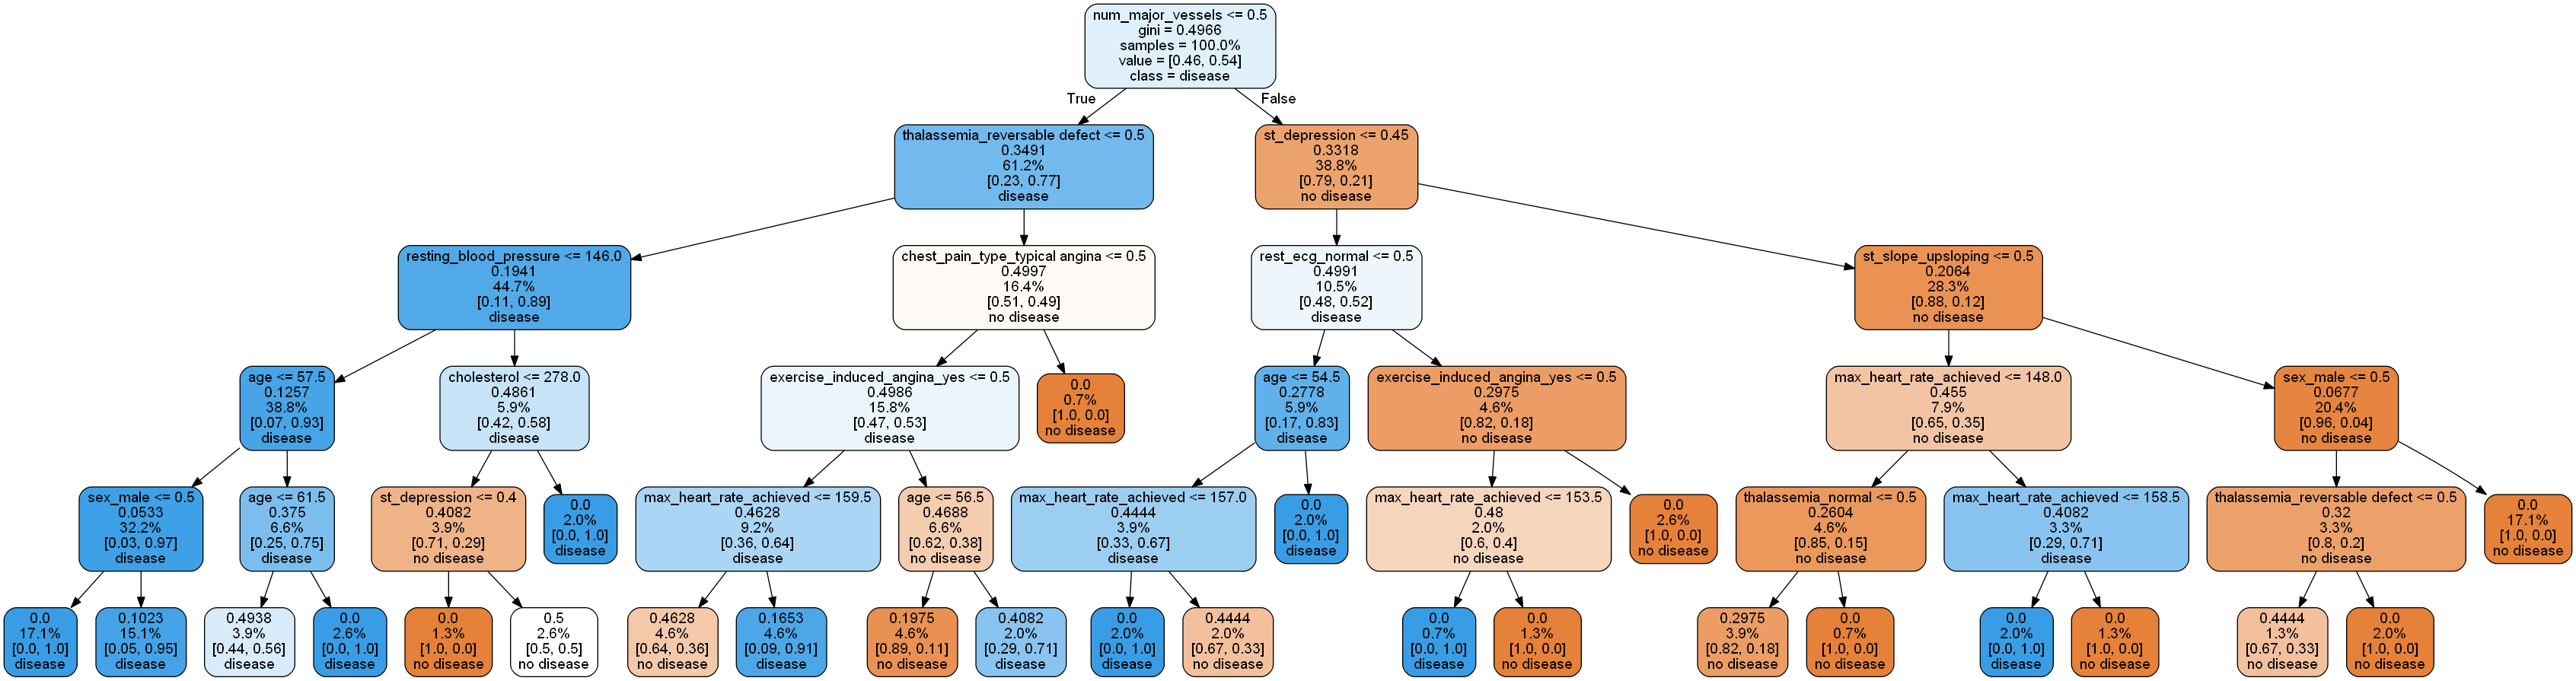

In [16]:
# Display graph
from IPython.display import Image
Image(filename = 'tree.png')

<b> Model evaluation <b>

In [17]:
y_predict = model.predict(X_test)
y_pred_quant = model.predict_proba(X_test)[:, 1]
y_pred_bin = model.predict(X_test)

In [18]:
# confusion matrix
confusion_matrix = confusion_matrix(y_test, y_pred_bin)
confusion_matrix

array([[30,  5],
       [ 5, 21]])

In [19]:
# specificity & sensitivity
total=sum(sum(confusion_matrix))

sensitivity = confusion_matrix[0,0]/(confusion_matrix[0,0]+confusion_matrix[1,0])
print('Sensitivity : ', sensitivity )

specificity = confusion_matrix[1,1]/(confusion_matrix[1,1]+confusion_matrix[0,1])
print('Specificity : ', specificity)

Sensitivity :  0.857142857143
Specificity :  0.807692307692


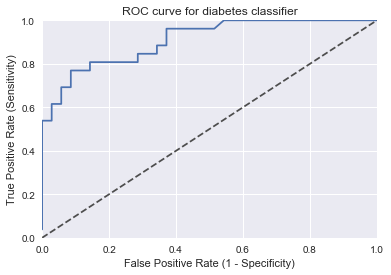

In [20]:
# ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_quant)

fig, ax = plt.subplots()
ax.plot(fpr, tpr)
ax.plot([0, 1], [0, 1], transform=ax.transAxes, ls="--", c=".3")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve for diabetes classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

In [21]:
# Area under roc curve
auc(fpr, tpr)

0.90824175824175823

Pretty good performance :)

<a id='section4'></a>

Now let's see what the model gives us from the ML explainability tools.

**Permutation importance** is the first tool for understanding a machine-learning model, and involves shuffling individual variables in the validation data (after a model has been fit), and seeing the effect on accuracy.


In [22]:
perm = PermutationImportance(model, random_state=1).fit(X_test, y_test)
eli5.show_weights(perm, feature_names = X_test.columns.tolist())

Weight,Feature
0.0426 ± 0.0491,st_depression
0.0361 ± 0.0131,thalassemia_fixed defect
0.0295 ± 0.0245,num_major_vessels
0.0197 ± 0.0131,chest_pain_type_atypical angina
0.0197 ± 0.0245,max_heart_rate_achieved
0.0131 ± 0.0245,age
0.0098 ± 0.0161,thalassemia_reversable defect
0.0098 ± 0.0161,exercise_induced_angina_yes
0.0066 ± 0.0262,st_slope_upsloping
0.0033 ± 0.0245,sex_male


So, it looks like the most important factors in terms of permutation is a thalessemia result of 'reversable defect'. The high importance of 'max heart rate achieved' type makes sense, as this is the immediate, subjective state of the patient at the time of examination (as opposed to, say, age, which is a much more general factor).

Let's take a closer look at the number of major vessles using a **Partial Dependence Plot**. These plots vary a single variable in a single row across a range of values and see what effect it has on the outcome. It does this for several rows and plots the average effect. Let's take a look at the 'num_major_vessels' variable, which was at the top of the permutation importance list,

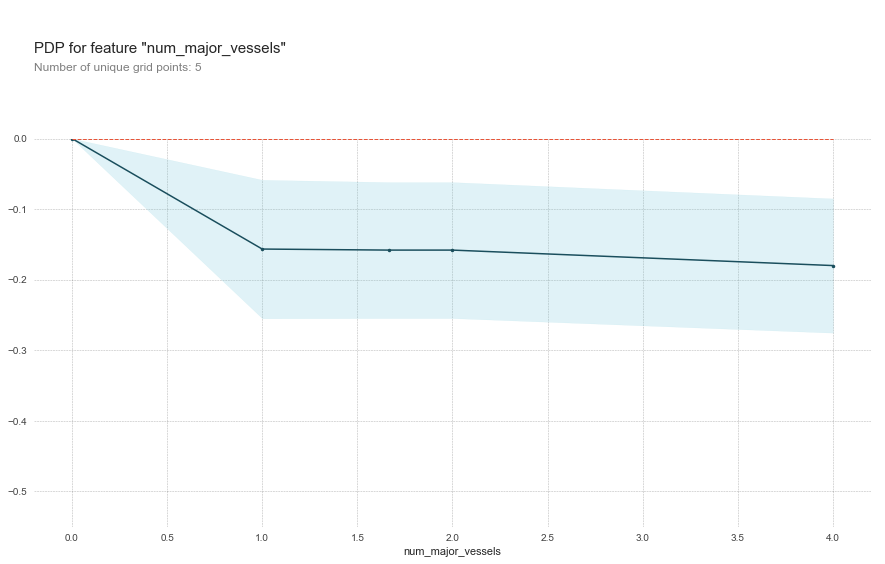

In [23]:
base_features = df.columns.values.tolist()
base_features.remove('target')

feat_name = 'num_major_vessels'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

So, we can see that as the number of major blood vessels *increases*, the probability of heart disease *decreases*. That makes sense, as it means more blood can get to the heart.

What about the 'age',

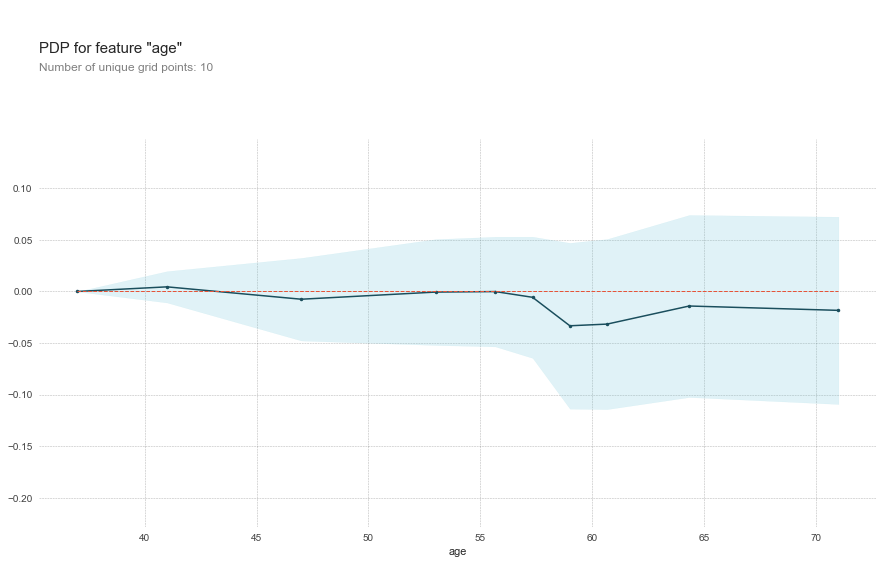

In [24]:
feat_name = 'age'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

That's a bit odd. The higher the age, the lower the chance of heart disease? Althought the blue confidence regions show that this might not be true (the red baseline is within the blue zone).

What about the 'st_depression',

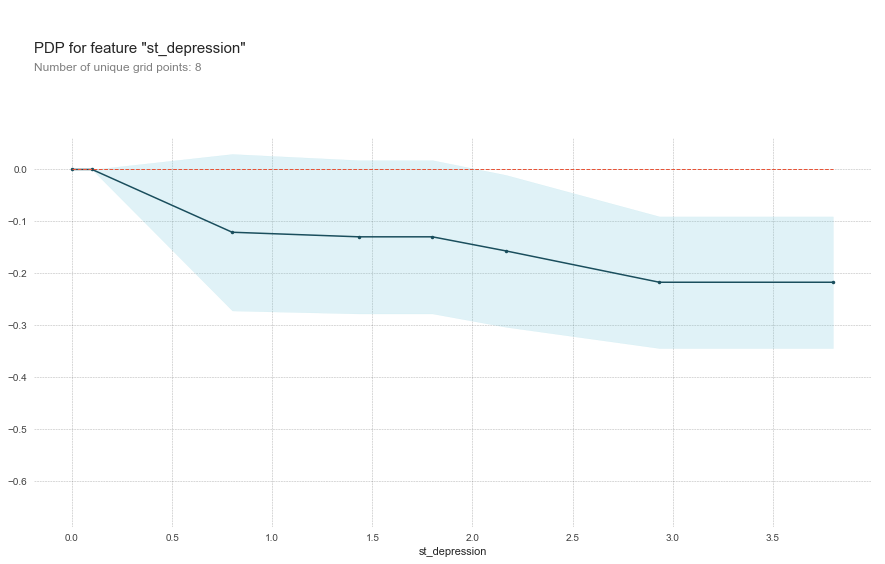

In [25]:
feat_name = 'st_depression'
pdp_dist = pdp.pdp_isolate(model=model, dataset=X_test, model_features=base_features, feature=feat_name)

pdp.pdp_plot(pdp_dist, feat_name)
plt.show()

Interestingly, this variable also shows a reduction in probability the higher it goes.

So, this variable, which is described as 'ST depression induced by exercise relative to rest', seems to suggest the higher the value the higher the probability of heart disease, but the plot above shows the opposite. Perhaps it's not just the depression amount that's important, but the interaction with the slope type? Let's check with a 2D PDP.

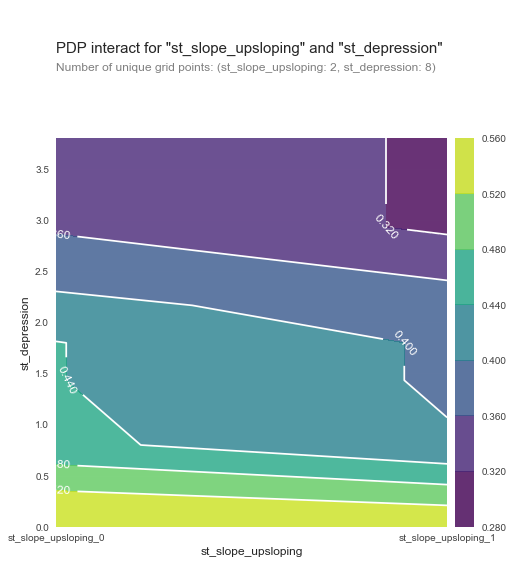

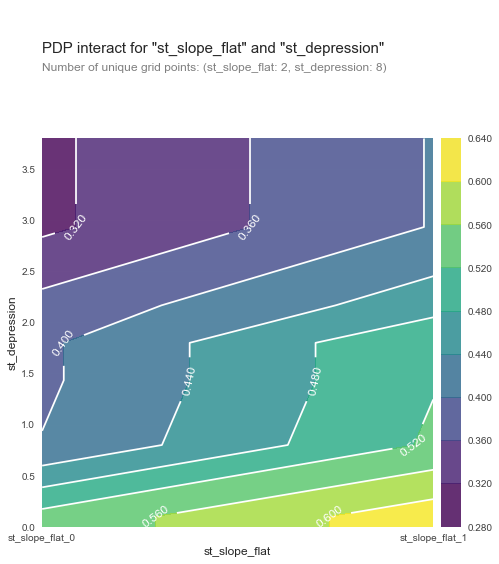

In [26]:
inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_upsloping', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_upsloping', 'st_depression'], plot_type='contour')
plt.show()

inter1  =  pdp.pdp_interact(model=model, dataset=X_test, model_features=base_features, features=['st_slope_flat', 'st_depression'])

pdp.pdp_interact_plot(pdp_interact_out=inter1, feature_names=['st_slope_flat', 'st_depression'], plot_type='contour')
plt.show()

It looks like a low depression is bad in both cases. Odd.

Let's see what the SHAP values tell us. These work by showing the influence of the values of every variable in a single row, compared to their baseline values.

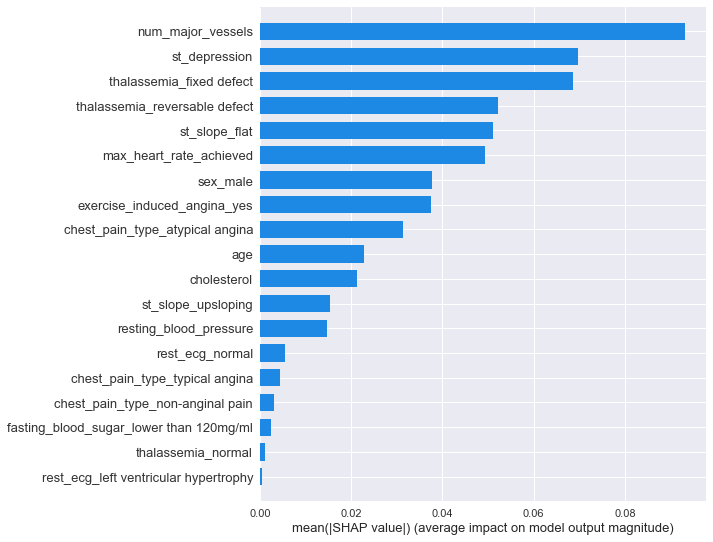

In [27]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values[1], X_test, plot_type="bar")


The number of major vessels is at the top. Let's use a summary plot of the SHAP values,

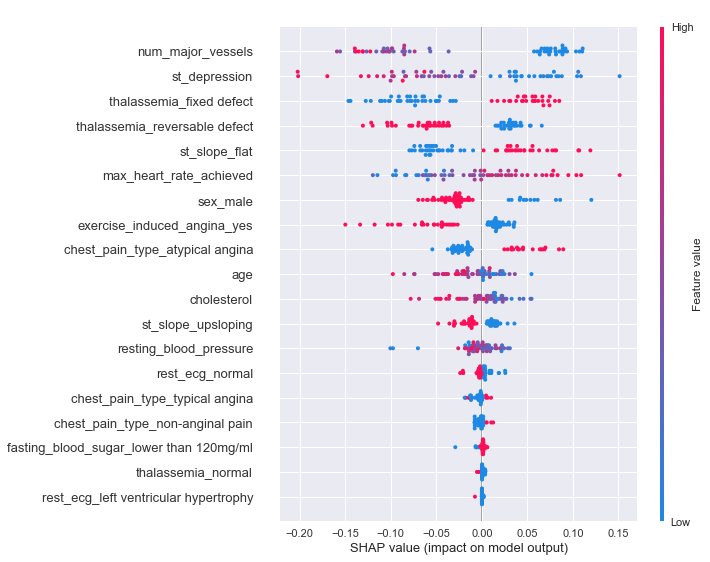

In [28]:
shap.summary_plot(shap_values[1], X_test)

The number of major vessels division is pretty clear, and it's saying that low values are bad (blue on the right). The thalassemia 'reversable defect' division is very clear (yes = red = good, no = blue = bad).

You can see some clear separation in many of the other variables. Exercise induced angina has a clear separation, although not as expected, as 'no' (blue) *increases* the probability. Another clear one is the st_slope. It looks like when it's flat, that's a bad sign (red on the right).

It's also odd is that the men (red) have a *reduced* chance of heart disease in this model. Why is this? Domain knowledge tells us that men have a greater chance.

Next, let's pick out individual patients and see how the different variables are affecting their outcomes,

In [29]:
def heart_disease_risk_factors(model, patient):

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(patient)
    shap.initjs()
    return shap.force_plot(explainer.expected_value[1], shap_values[1], patient)

In [30]:
data_for_prediction = X_test.iloc[1,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

For this person, their prediction is 28% (compared to a baseline of 57%). Many things are working in their favour, including having a major vessel, a reversible thalassemia defect, and *not* having a flat st_slope.

Let's check another,

In [31]:
data_for_prediction = X_test.iloc[3,:].astype(float)
heart_disease_risk_factors(model, data_for_prediction)

For this person, their prediction is 70% (compared to a baseline of 58.4%). Not working in their favour are things like having no major vessels, a flat st_slope, and *not* a reversible thalassemia defect.

We can also plot something called 'SHAP dependence contribution plots' (learn more [here](https://www.kaggle.com/dansbecker/advanced-uses-of-shap-values)), which are pretty self-explanatory in the context of SHAP values,

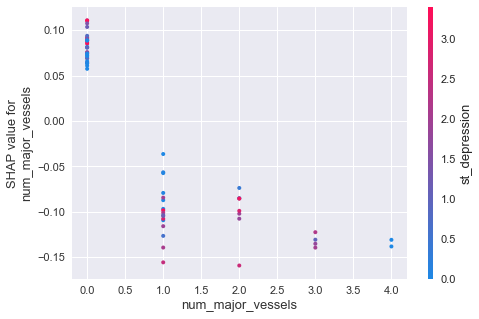

In [32]:
ax2 = fig.add_subplot(224)
shap.dependence_plot('num_major_vessels', shap_values[1], X_test, interaction_index="st_depression")

You can see the stark effect on the number of major vessels, but there doesn't seem to be a lot to take from the colour (st_depression).

The final plot, for me, is one of the most effective. It shows the predictions and influencing factors for many (in this case 50) patients, all together. It's also interactive, which is great. Hover over to see *why* each person ended up either red (prediction of disease) or blue (prediction of no disease),

In [33]:
shap_values = explainer.shap_values(X_train.iloc[:50])
shap.force_plot(explainer.expected_value[1], shap_values[1], X_test.iloc[:50])

<a id='section5'></a>

# Conclusion

This dataset is old and small by today's standards. However, it's allowed us to create a simple model and then use various machine learning explainability tools and techniques to peek inside. At the start, I hypothesised, using domain knowledge that factors such as cholesterol and age would be major factors in the model. This dataset didn't show that. Instead, the number of major factors and aspects of ECG results dominated. I actually feel like I've learnt a thing or two about heart disease!

I suspect this sort of approach will become increasingly important as machine learning has a greater and greater role in health care.